In [1]:
import os
import random
import paddle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import gzip
import json

In [2]:
# 定义数据集读取器
def load_data(mode='train'):
    # 加载数据
    datafile = './work/mnist.json.gz'
    print('load data from ',datafile)
    data = json.load(gzip.open(datafile))
    print('data load done')
    train_set, val_set, eval_set = data
    IMG_ROWS = 28
    IMG_COLS = 28
    if mode == 'train':
        imgs, labels = train_set[0], train_set[1]
    elif mode == 'valid':
        imgs, labels = val_set[0], val_set[1]
    elif mode == 'eval':
        imgs, labels = eval_set[0], eval_set[1]
    else:
        raise Exception('mode can only be one of ["train","valid","eval"]')
    imgs_length = len(imgs)
    assert len(imgs) == len(labels), '数据和数据标签length 不同'
    index_list = list(range(imgs_length))
    BATCHSIZE = 100
    
    def data_generator():
        if mode == 'train':
            random.shuffle(index_list)
        imgs_list = []
        labels_list = []
        for i in index_list:
            #卷积
            img = np.reshape(imgs[i],[1,IMG_ROWS,IMG_COLS]).astype('float32')
            label = np.reshape(labels[i],[1]).astype('int64')
            imgs_list.append(img)
            labels_list.append(label)
            if len(imgs_list) ==BATCHSIZE:
                yield np.array(imgs_list),np.array(labels_list)
                imgs_list = []
                labels_list = []
        if len(imgs_list) > 0:
            yield np.array(imgs_list),np.array(labels_list)
    return data_generator


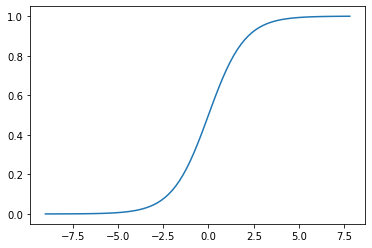

In [3]:
# sigmod
def sigmod(x):
    return 1./(1.+np.exp(-x))
x=np.arange(-9,8,0.2)
y=sigmod(x)
plt.plot(x,y)
plt.show()

In [4]:
# 训练
import paddle.nn.functional as F
from paddle.nn import Linear

class MNIST(Linear):
    def __init__(MNIST,self):
        super(MNIST,self).__init()
        self.fc1 = Linear(in_features=784,out_features=10)
        self.fc2 = Linear(in_features=10,out_features=10)
        self.fc3 = Linear(in_features=10,out_features=10)
        
    def forward(self, inputs):
        inputs = paddle.reshape(inputs, [inputs.shape[0],784])
        outputs1 = self.fc1(inputs)
        outputs1 = F.sigmoid(outputs1)
        outputs2 = self.fc2(outputs1)
        outputs2 = F.sigmoid(outputs2)
        outputs_final = self.fc3(outputs2)
        return outputs_final


In [5]:
import paddle
from paddle.nn import Conv2D,MaxPool2D,Linear
import paddle.nn.functional as F

class MNIST(paddle.nn.Layer):
    def __init__(self):
        super(MNIST, self).__init__()
        self.conv1 = Conv2D(in_channels=1,out_channels=20,kernel_size=5,stride=1,padding=2)
        self.max_pool1 = MaxPool2D(kernel_size=2,stride=2)
        self.conv2 = Conv2D(in_channels=20, out_channels=20, kernel_size=5, stride=1, padding=2)
        self.max_pool2 = MaxPool2D(kernel_size=2, stride=2)
        self.fc = Linear(in_features=980,out_features=10)
        
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool2(x)
        x = paddle.reshape(x,[x.shape[0],-1])
        x = self.fc(x)
        return x
    

In [6]:
def train(model):
    paddle.device.set_device('gpu:0')
    model.train()
    train_loader = load_data('train')
    print('start')
    opt = paddle.optimizer.Adam(learning_rate=0.01,parameters=model.parameters())
    
    EPOCH_NUM = 10
    
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            images, labels = data
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels)
            predicts = model(images)
            loss = F.cross_entropy(predicts,labels)
            avg_loss = paddle.mean(loss)
            
            #每训练200批次的数据，打印当前Loss的情况
            if batch_id % 100 == 0:
                print("epoch: {},batch: {}, loss is {}".format(epoch_id,batch_id,avg_loss.numpy()))
            avg_loss.backward()
            opt.step()
            opt.clear_grad()
    
    paddle.save(model.state_dict(),'mnist.pdparams')

model = MNIST()
train(model)

load data from  ./work/mnist.json.gz
data load done
start
epoch: 0,batch: 0, loss is [2.5545762]
epoch: 0,batch: 100, loss is [0.21295512]
epoch: 0,batch: 200, loss is [0.07986146]
epoch: 0,batch: 300, loss is [0.11240919]
epoch: 0,batch: 400, loss is [0.04219489]
epoch: 1,batch: 0, loss is [0.11972559]
epoch: 1,batch: 100, loss is [0.06347153]
epoch: 1,batch: 200, loss is [0.04449221]
epoch: 1,batch: 300, loss is [0.11229464]
epoch: 1,batch: 400, loss is [0.17635716]
epoch: 2,batch: 0, loss is [0.05646669]
epoch: 2,batch: 100, loss is [0.0245186]
epoch: 2,batch: 200, loss is [0.10255778]
epoch: 2,batch: 300, loss is [0.06937167]
epoch: 2,batch: 400, loss is [0.01439047]
epoch: 3,batch: 0, loss is [0.03178119]
epoch: 3,batch: 100, loss is [0.04980913]
epoch: 3,batch: 200, loss is [0.00524129]
epoch: 3,batch: 300, loss is [0.01367021]
epoch: 3,batch: 400, loss is [0.04583795]
epoch: 4,batch: 0, loss is [0.00776036]
epoch: 4,batch: 100, loss is [0.01295991]
epoch: 4,batch: 200, loss is [

In [9]:
predict_data = paddle.vision.datasets.MNIST(mode='test')
predict_data = np.array(predict_data)
err_num = 0
for i in range(0,100):
    im = predict_data[i][0]
    im = np.reshape(im,[1,1,28,28]).astype('float32')

    model = MNIST()
    params_file_path = 'mnist.pdparams'
    param_dict = paddle.load(params_file_path)
    model.load_dict(param_dict)
    model.eval()
    tensor_img = im
    result = model(paddle.to_tensor(tensor_img))
    if np.argmax(result.numpy()) != predict_data[i][1][0]:
        err_num += 1
    print('本次预测的结果是：', np.argmax(result.numpy()),'实际是：',predict_data[i][1][0])
print(err_num)

C:\Users\25564\AppData\Local\Temp\ipykernel_13512\2362371093.py:2: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  predict_data = np.array(predict_data)
C:\Users\25564\AppData\Local\Temp\ipykernel_13512\2362371093.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  predict_data = np.array(predict_data)


本次预测的结果是： 7 实际是： 7
本次预测的结果是： 2 实际是： 2
本次预测的结果是： 1 实际是： 1
本次预测的结果是： 0 实际是： 0
本次预测的结果是： 4 实际是： 4
本次预测的结果是： 1 实际是： 1
本次预测的结果是： 4 实际是： 4
本次预测的结果是： 9 实际是： 9
本次预测的结果是： 8 实际是： 5
本次预测的结果是： 9 实际是： 9
本次预测的结果是： 0 实际是： 0
本次预测的结果是： 6 实际是： 6
本次预测的结果是： 9 实际是： 9
本次预测的结果是： 0 实际是： 0
本次预测的结果是： 1 实际是： 1
本次预测的结果是： 5 实际是： 5
本次预测的结果是： 9 实际是： 9
本次预测的结果是： 7 实际是： 7
本次预测的结果是： 3 实际是： 3
本次预测的结果是： 4 实际是： 4
本次预测的结果是： 9 实际是： 9
本次预测的结果是： 6 实际是： 6
本次预测的结果是： 6 实际是： 6
本次预测的结果是： 5 实际是： 5
本次预测的结果是： 4 实际是： 4
本次预测的结果是： 0 实际是： 0
本次预测的结果是： 7 实际是： 7
本次预测的结果是： 4 实际是： 4
本次预测的结果是： 0 实际是： 0
本次预测的结果是： 1 实际是： 1
本次预测的结果是： 3 实际是： 3
本次预测的结果是： 1 实际是： 1
本次预测的结果是： 3 实际是： 3
本次预测的结果是： 4 实际是： 4
本次预测的结果是： 7 实际是： 7
本次预测的结果是： 2 实际是： 2
本次预测的结果是： 7 实际是： 7
本次预测的结果是： 1 实际是： 1
本次预测的结果是： 2 实际是： 2
本次预测的结果是： 1 实际是： 1
本次预测的结果是： 1 实际是： 1
本次预测的结果是： 7 实际是： 7
本次预测的结果是： 4 实际是： 4
本次预测的结果是： 2 实际是： 2
本次预测的结果是： 3 实际是： 3
本次预测的结果是： 5 实际是： 5
本次预测的结果是： 1 实际是： 1
本次预测的结果是： 2 实际是： 2
本次预测的结果是： 4 实际是： 4
本次预测的结果是： 4 实际是： 4
本次预测的结果是： 6 实际是： 6
本次预测的结果是： 3 实际是： 3
本次预测的结果是： 5 